In [1]:
using Plots, Random, FFTW, Colors, Statistics, LinearAlgebra, EllipsisNotation, Wavelets, PaddedViews,
    AbstractOperators, OffsetArrays

## Read Data

In [2]:
d₁, d₂, d₃, m = 300, 224, 48, 4
kSpace_orig = Array{ComplexF32}(undef, d₁, d₂, d₃, m)
read!("../data.dat", kSpace_orig)
kSpace_orig = ntoh.(kSpace_orig) # big-endian to system default
kSpace_CF64_orig = ComplexF64.(kSpace_orig);

## Prepare Data

In [71]:
image4D = abs.(ifft(kSpace_CF64_orig, [1,2,3]))              # Discard phase
image3D = dropdims(mean(image4D, dims=4), dims=4)            # Averaging measurements
phase2D = exp.(angle.(ifft(kSpace_CF64_orig[..,1])) .* 1im)  # Get phase of first measurement
image2D = image3D[:,:,end÷2] .* phase2D[:,:,end÷2]           # Keep only first slice and add phase
image2D ./= maximum(abs, image2D)                            # Normalize data
kSpace = fft(image2D);                                       # Simulate measurement

In [8]:
imSize, imType, kSize, kType = size(image2D), eltype(image2D), size(kSpace), eltype(kSpace)

((300, 224), Float64, (300, 224), Complex{Float64})

## Visualize

In [9]:
function imshow(img::Array{T, 2}; shift = false) where T<:Number
    shift ? 
        plot(Gray.(abs.(fftshift(img, [1]))'), seriestype=:image) :
        plot(Gray.(abs.(img)'), seriestype=:image)
end

imshow (generic function with 1 method)

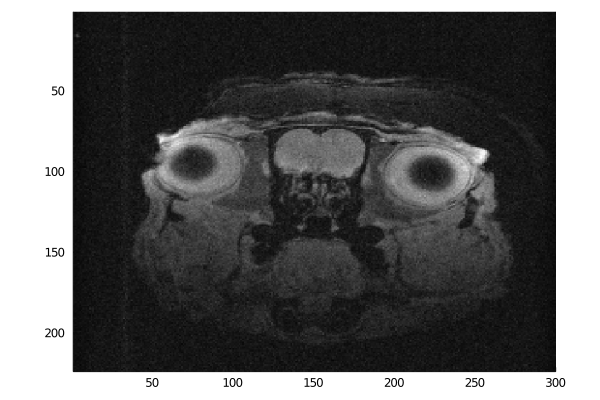

In [72]:
imshow(image2D, shift = true)

## Simulate Measurement

### Generate potential density function (pdf)
**Goal:** Generate a pdf that satisfies the following criteria:
 1. Values of pdf are valid probability values (i.e. they are in the rage of $[0,1]$)
 1. There is an area in the middle of the image which has a predefined radius, and inside that area we perform no undersampling
 1. Left to the fully sampled area, the probability should be proportional to the distance from the center raised to the `p`th power
 1. Right to the fully sampled area, the probability should be $0$.
 1. Integral of the pdf normalized by the area of the support of the pdf has to be equal to the the undersampling factor
   - That, of course, violates the definition of pdf
   - so actually it is only a pdf-like function that maps each pixel (in k-space) to a probability value which tells us, how likely we will pick that value during undersampling
   - In other words, we can say that the expected number of undersampled values should be equal to the undersampling factor times the area of the support of the pdf
   
**Symbolic calculation:**

1-3rd conditions above:
$$
PDF: [-1,1] \rightarrow [0,1],
PDF(x) = \begin{cases}
(1-|x|)^p + b : x < -r \\
1 : -r \le x \le r \\
0 : r < x
\end{cases}$$

4th condition above:
$$uf = \int_{-1}^{1} PDF(x) dx = \int_{-1}^{-r} \left[(1+x)^p + b\right] dx + \int_{-r}^{r} 1 dx = \frac{(1-r)^{p+1}}{p+1} + b(1-r) + 2r$$

Calculating bias:
$$b = \frac{uf - (1-r)^{p+1}(p+1)^{-1} - 2r}{(1-r)}$$

**Input:**
 - `dataLength` - length of output vector
 - `p` - power of polynomial
 - `uf` - undersampling factor (e.g. 0.5 for half)
 - `normType` - 1 or 2 for L1 or L2 distance measure
 - `fs_radius` - radius of fully sampled center
 - `disp` - display output
 
**Output:**
 - the pdf
 
*Corresponding Matlab code:* `utils/genPDF.m`

In [153]:
function generatePDF(dataLength, uf; distType = 2, r = 0.1, max_p = 50, disp = false)
    pdf = nothing
    
    for p = 0:max_p

        start_idx, last_idx = -floor(Int, dataLength/2), floor(Int, dataLength/2)-1
        fs_start, fs_end = floor(Int, -r * dataLength), ceil(Int, r * dataLength)
        #distance_map = range(1, r, length = abs(start_idx-fs_start))
        distance_map = range(r, 1, length = last_idx-fs_end)

        pdf = OffsetVector{Float64}(undef, start_idx:last_idx)
        #pdf[start_idx:fs_start-1] = (1 .- distance_map).^p
        pdf[start_idx:fs_start-1] .= 0
        pdf[fs_start:fs_end] .= 1
        #pdf[fs_end+1:last_idx] .= 0
        pdf[fs_end+1:last_idx] = (1 .- distance_map).^p
        
        # shift the exponential part to fullfil condition 4
        diff = uf * dataLength - sum(pdf)
        diff < 0 && continue
        #pdf[start_idx:fs_start-1] .+= diff / length(pdf[start_idx:fs_start-1])
        pdf[fs_end+1:last_idx] .+= diff / (last_idx-fs_end)
        all(x -> 0 <= x <= 1, pdf) && break
    end
    
    (pdf isa Nothing || any(x -> x < 0 || 1 < x, pdf)) && error("infeasible with given parameters")
    
    collect(pdf)
end

generatePDF (generic function with 1 method)

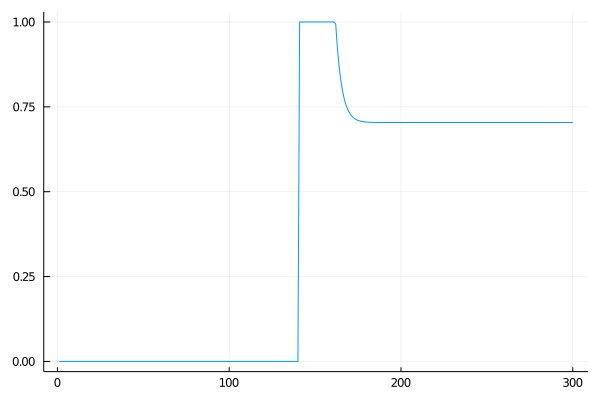

In [216]:
undersampling_rate, fully_sampled_radius = 0.4, 1/32
pdf = generatePDF(imSize[1], undersampling_rate, r = fully_sampled_radius, disp = true)
#pdf = zeros(imSize[1])
#pdf[1:round(Int,imSize[1]*undersampling_rate)] .= 1
plot(pdf, legend=false)

In [217]:
sum(pdf), undersampling_rate * 300

(119.99999999999997, 120.0)

### Generating sampling mask
A Monte-Carlo algorithm to generate a sampling pattern with minimum peak interference. The number of samples will be sum(pdf) +- tol

**Why do we use Monte-Carlo algorithm?**
 - Finding optimal sampling scheme is combinatorial problem → very difficult
 - Choosing samples random: incoherent and near-optimal solution
 - Monte-Carlo design procedure:
   - Choose a grid size based on desired resolution and FOV of object
   - Construct a probability density function (pdf) (e.g. using the "power of the distance from origin" rule)
   - Draw indices from the grid according to the constructed pdf
   - Repeat the previous step many times and pick a result with lower peak interference in TPSF (Transform Point Spread Function) to avoid samplings which are far from optimal
 - That sampling pattern can be re-used in future scans

**Inputs:**
 - `pdf` - probability density function to choose samples from
 - `iter` - number of tries
 - `tol`  - the deviation from the desired number of samples in samples
 
**Output:**
 - sampling pattern
 
*Corresponding Matlab code:* `utils/genSampling.m`

In [156]:
function generate_mask(pdf, imSize, iter, tol; max_inner_iter = 100)
    NSV(pdf) = sum(pdf) # Number of Sampled Values
    function generate_mask(pdf)
        mask = nothing
        for i in 1:max_inner_iter
            mask = [rand() < e for e in pdf]
            diff = abs(NSV(mask) - NSV(pdf))
            diff < tol*length(mask) && break
            i == max_inner_iter && error("infeasible with given parameters")
        end
        return mask
    end
    
    masks = [generate_mask(pdf) for i = 1:iter]
    F⁻¹ₘₐₛₖₛ = [ifft(mask./pdf) for mask in masks]                    # Inverse Fourier transform
    TPSFₘₐₓ = [maximum(abs.(F⁻¹ₘₐₛₖ[2:end])) for F⁻¹ₘₐₛₖ in F⁻¹ₘₐₛₖₛ] # height of larges sidelobe
    
    (masks[argmin(TPSFₘₐₓ)] * ones(imSize[2])') .== 1
end

generate_mask (generic function with 1 method)

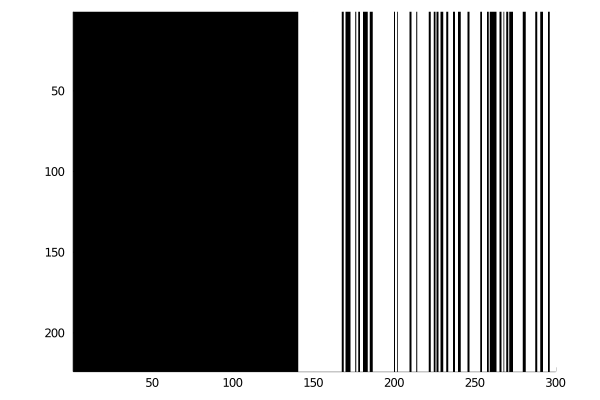

In [218]:
mask = generate_mask(pdf, imSize, 50, 0.01)
imshow(mask .* 1)

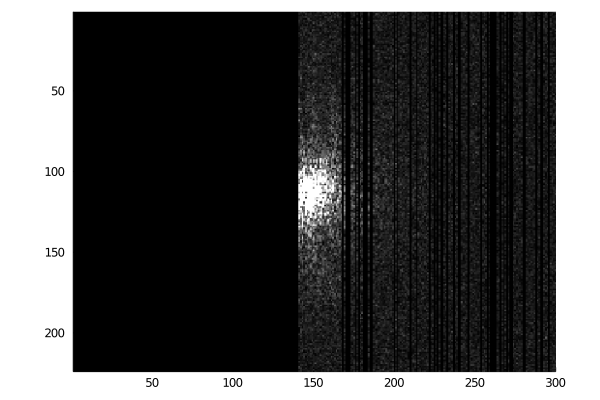

In [219]:
y_measured = mask .* kSpace
imshow(y_measured ./ maximum(abs, y_measured)*10)

In [110]:
mse(img) = norm(abs.(img) - abs.(image2D))

mse (generic function with 1 method)

## Baseline: Zero-filling reconstruction

mse(image2D_zf) = 17.038736667925892


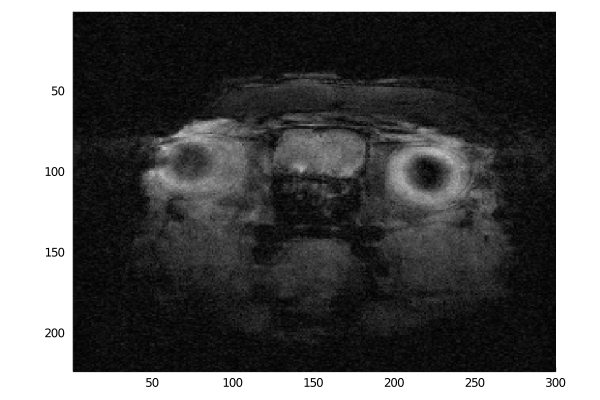

In [220]:
image2D_zf = abs.(ifft(y_measured))
@show mse(image2D_zf)
imshow(image2D_zf, shift = true)

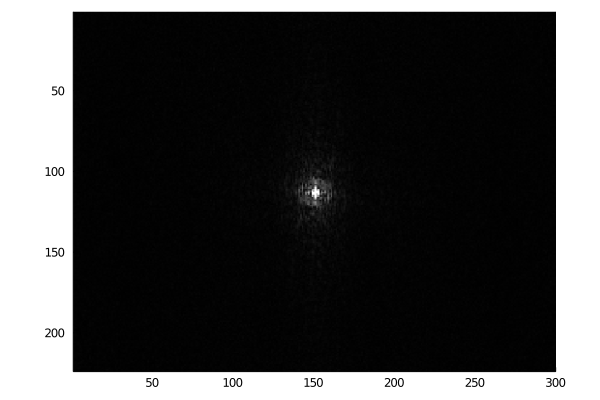

In [221]:
tmp = fftshift(fft(image2D_zf))
imshow(tmp ./ maximum(abs, tmp)*10)

In [222]:
function homodyne_reconstruction(Mₚₖ, mask, undersampling_rate, fully_sampled_radius)
    
    # Mₚₖ: partial k-space data
    # Mₛ: symmetrically sampled k-space data
    
    dataLength = size(Mₚₖ, 1)
    start_idx = -floor(Int, dataLength/2)
    r = fully_sampled_radius
    fs_start = abs(start_idx - floor(Int, -r * dataLength))
    fs_end = abs(start_idx - ceil(Int, r * dataLength))
    
    Mₛ = similar(Mₚₖ)
    Mₛ .= 0
    Mₛ[fs_start:fs_end, :] .= Mₚₖ[fs_start:fs_end, :]
    
    W = zeros(size(Mₚₖ)...)
    W[fs_end:end, :] .= 2
    ramp = collect(range(2, 0, length = fs_end - fs_start + 1))
    W[fs_start:fs_end, :] = repeat(ramp, 1, size(Mₚₖ, 2))
    
    mₛ = ifft(Mₛ)
    mₚₖ = ifft(W .* Mₚₖ)
    
    p = exp.(-1im .* angle.(mₛ))  # phase correction image
    
    real.(mₚₖ .* p)
end

homodyne_reconstruction (generic function with 1 method)

mse(image2D_hd) = 23.138079804226546


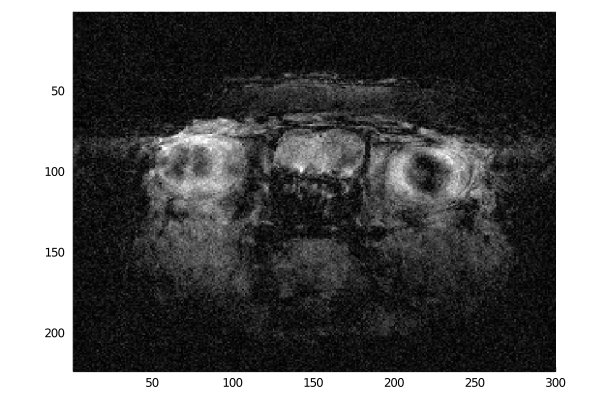

In [223]:
image2D_hd = homodyne_reconstruction(y_measured, mask, undersampling_rate, fully_sampled_radius)
@show mse(image2D_hd)
imshow(image2D_hd, shift = true)

In [229]:
function POCS(Mₚₖ, mask, undersampling_rate, fully_sampled_radius)
    
    # Mₚₖ: partial k-space data
    
    dataLength = size(Mₚₖ, 1)
    start_idx = -floor(Int, dataLength/2)
    r = fully_sampled_radius
    fs_start = abs(start_idx - floor(Int, -r * dataLength))
    fs_end = abs(start_idx - ceil(Int, r * dataLength))
    
    Mₛ = similar(Mₚₖ) # Mₛ: symmetrically sampled k-space data
    Mₛ .= 0
    Mₛ[fs_start:fs_end, :] = Mₚₖ[fs_start:fs_end, :]
    mₛ = ifft(Mₛ)
    p = exp.(1im .* angle.(mₛ))  # phase correction image
    
    Mᵢ = similar(Mₚₖ)
    Mᵢ[1:fs_end,:] .= 0
    for i in 1:1
        Mᵢ[fs_start:end, :] = Mₚₖ[fs_start:end, :]
        mᵢ = ifft(Mᵢ)
        Mᵢ = fft(p .* abs.(mᵢ))
    end
    #Mᵢ[1:fs_end,:] = Mₚₖ[1:fs_end, :]
    
    Mᵢ
end

POCS (generic function with 1 method)

mse(image2D_POCS) = 17.038736667925892


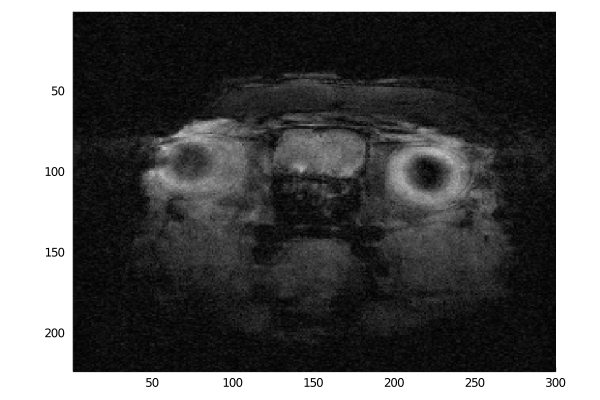

In [230]:
kSpace_POCS = POCS(y_measured, mask, undersampling_rate, fully_sampled_radius)
image2D_POCS = ifft(kSpace_POCS)
@show mse(image2D_POCS)
imshow(abs.(image2D_POCS), shift = true)

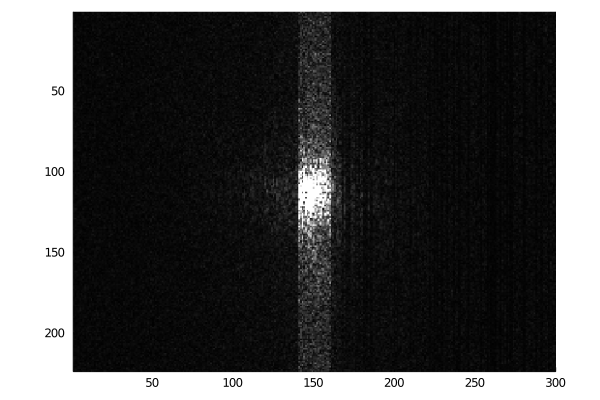

In [231]:
imshow(kSpace_POCS ./ maximum(abs, kSpace_POCS)*10)

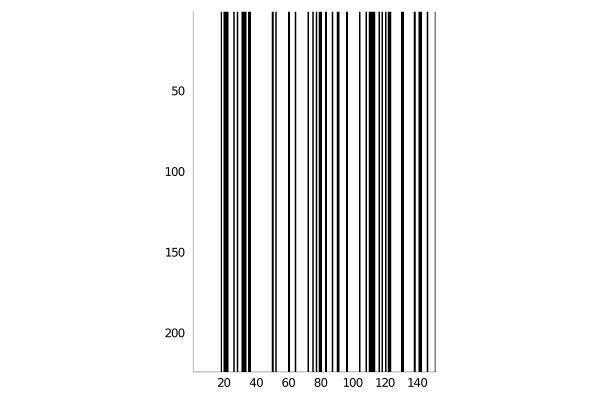

In [244]:
half_mask = fftshift(mask)[1:kSize[1],1:kSize[2]]
imshow(half_mask .* 1)

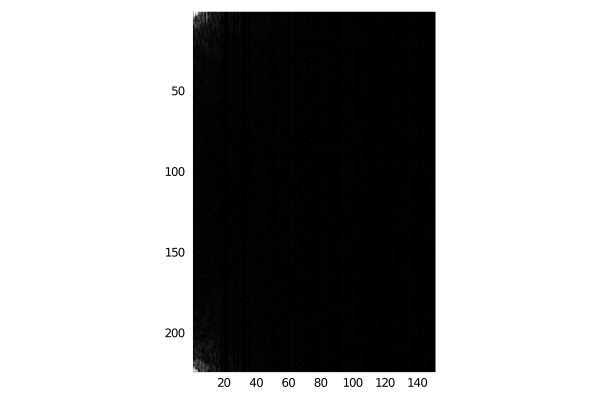

In [245]:
tmp_true = half_mask .* rfft(abs.(image2D))
imshow(tmp_true ./ maximum(abs, tmp_true)*10)

In [246]:
tmp = half_mask .* rfft(image2D_zf)
maximum(abs, (tmp - tmp_true))

2007.8057769708812

In [247]:
tmp = half_mask .* rfft(image2D_hd)
maximum(abs, (tmp - tmp_true))

2377.903825595552

In [248]:
tmp = half_mask .* rfft(abs.(image2D_POCS))
maximum(abs, (tmp - tmp_true))

2007.8057769708794

## Compressed Sensing

### Image reconstruction
- **TV (Total Variance):** L1 norm of finite differences image
- **Original problem** to be solved: *minimize* $\lvert\lvert \Psi m \rvert\rvert_1$ *such that* $\lvert\lvert \mathcal{F}_u m - y \rvert\rvert_2 < \epsilon$
  - it is an constrainted convex optimization problem
- Consider the **unconstrainted problem** in **Lagrangian form**: $argmin_m \lvert\lvert\mathcal{F}_u m - y \rvert\rvert_2^2 + \lambda \lvert\lvert\Psi m \rvert\rvert_1$, where $\lambda$ is a regularization paramater that determines the trade-off between data consistency and sparsity
  - if $\lambda$ properly selected, then the two problem statements yield same results
  - $\lambda$ can be determined by trying many values and choosing one so that $\lvert\lvert\mathcal{F}_u m - y \rvert\rvert_2 \approx \epsilon$
- **Unconstrained problem then can be solved** by nonlinear conjugate gradient descent (CG) algorithm using $f(m) = argmin_m \lvert\lvert\mathcal{F}_u m - y \rvert\rvert_2^2 + \lambda \lvert\lvert\Psi m \rvert\rvert_1$ as cost function
- Computation of $\mathcal{F}_u f(m)$
  - $\nabla f(m) = 2 \mathcal{F}_u^*(\mathcal{F}_u m - y) + \lambda \nabla \lvert\lvert \Psi m \rvert\rvert_1$
  - $\mathcal{l}^1$ norm is sum of absolute values → Problem: absolute value funciton is not a smooth functions → equation above is not well-defined for all values of $m$
  - Instead of absolute value function we use a smooth function: $\lvert x \rvert \approx \sqrt{x*x + \mu}$, where $\mu$ is a positive smoothing parameter
    - With this approximation: $\frac{d \lvert x \rvert}{dx} \approx \frac{x}{\sqrt{x*x + \mu}}$
  - Let $W$ be a diagonal matrix with diagonal elements $w_i = \sqrt{(\Psi m)_i*(\Psi m)_i + \mu}$
    - Then $\nabla f(m) = 2 \mathcal{F}_u^*(\mathcal{F}_u m - y) + \lambda \Psi^* W^{-1} \Psi m$
  - In practice $\mu \in [10^{-15}, 10^{-6}]$ 

In [238]:
plan = plan_rfft(abs.(image2D), [1,2])
fft_temp = similar(plan * abs.(image2D))
kSize = size(fft_temp)
inv_plan = plan_irfft(fft_temp, size(image2D, 1), [1,2]);
normalizer = √(length(image2D) / 2)
half_mask = mask[1:kSize[1],1:kSize[2]]
Fᵤ = MyLinOp(imType, imSize, kType, kSize,
    (b, x) -> b .= 1/normalizer .* half_mask .* mul!(b, plan, x),
    (b, x) -> b .= normalizer .* mul!(b, inv_plan, fft_temp .= x))

A  ℝ^(300, 224) -> ℂ^(151, 224) 

In [239]:
y = Fᵤ * image2D_zf;

### Smoothed L1 norm

In [184]:
μ = real(imType(1e-15))
abs_smooth(x) = sqrt(x * conj(x) + μ)
norm₁(v) = sum(abs_smooth, v)
∇norm₁(v) = v ./ abs_smooth.(v)

∇norm₁ (generic function with 1 method)

In [185]:
norm₂(x) = norm(x)
norm₂²(x) = abs(vec(x)' * vec(x))

norm₂² (generic function with 1 method)

## Sparsifying transform

In [186]:
wt = wavelet(WT.Daubechies{4}(), WT.Filter, WT.Periodic)
transformed_size = 2 .^ (ceil.(Int, log2.(imSize)))
temp_wavelet = similar(image2D, transformed_size)
oneTo(x) = 1:x
Ψ = MyLinOp(imType, imSize, transformed_size,
    (b, x) -> begin
        img = PaddedView(0, x, size(b))
        dwt!(b, img, wt)
    end,
    (b, x) -> begin
        idwt!(temp_wavelet, x, wt)
        b .= @view temp_wavelet[oneTo.(imSize)...]
    end)

A  ℝ^(300, 224) -> ℝ^(512, 256) 

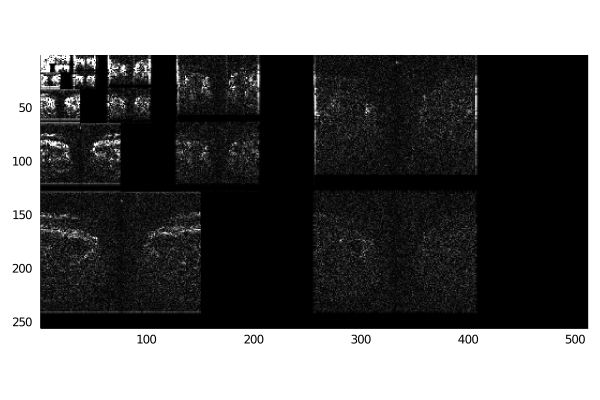

In [187]:
test = Ψ * abs.(image2D)
imshow(test*4)

### Total Variance

In [188]:
function _finite_differences!(Δx, x, d)
    last = size(Δx, d)
    𝟘 = zero(eltype(x))
    for i in axes(Δx, d)
        if i != last
            selectdim(Δx, d, i) .= selectdim(x, d, i) .- selectdim(x, d, i+1)
        else
            selectdim(Δx, d, i) .= 𝟘
        end
    end
end
function _second_order_finite_differences!(Δx, x, d, overwrite)
    last = size(Δx, d)
    𝟘, 𝟙 = zero(eltype(x)), one(eltype(x))
    for i in axes(Δx, d)
        if overwrite
            if i == 1
                selectdim(Δx, d, i) .= -𝟙 .* selectdim(x, d, i)
            elseif i != last
                selectdim(Δx, d, i) .= selectdim(x, d, i) .- selectdim(x, d, i-1)
            else
                selectdim(Δx, d, i) .= 𝟘
            end
        else
            if i == 1
                selectdim(Δx, d, i) .-= selectdim(x, d, i)
            elseif i != last
                selectdim(Δx, d, i) .+= selectdim(x, d, i) .- selectdim(x, d, i-1)
            end
        end
    end
    Δx
end

_second_order_finite_differences! (generic function with 1 method)

In [189]:
TV = MyLinOp(imType, imSize, (imSize..., length(imSize)),
    (∇, image) -> begin
        for d in 1:ndims(image)
            _finite_differences!(@view(∇[..,d]), image, d)
        end
        ∇
    end,
    (∇, image) -> begin
        for d in 1:ndims(image)-1
            @views _second_order_finite_differences!(∇, image[..,d], d, d == 1) 
        end
        ∇
    end)

A  ℝ^(300, 224) -> ℝ^(300, 224, 2) 

### Nonlinear Conjugate Gradient Descent with backtracking linear search

**Inputs**:
 - `y`: k-space measurements
 - `m_0`: initial value for reconstructed image
 - `f`: objective / cost function
 - `∇f`: gradient of objective
 - `tolGrad`: stopping criteria by gradient magnitude (optional, default: $10^{-4}$)
 - `maxIter`: stopping criteria by number of iterations (optional, default: $100$)
 - `lineSearchMaxIter`: stopping criteria for linear search (optional, default: $150$)
 - `initial_t₀, α, β`: line search parameters (optional, defaults: `initial_t₀`: $1$, `α`: $0.05$, `β`: $0.6$)

**Outputs**
 - `m`: numerical approximation for the image

In [210]:
function ncg_optimize(m₀, f, ∇f; tolGrad = 1e-4, maxIter = 100, lineSearchMaxIter = 150,
        α = 0.05, β = 0.6, initial_t₀ = 1, verbose = false)
    
    # Initialization
    dType = eltype(m₀)
    mₖ, gradₖ, t₀, α, β = m₀, ∇f(m₀), initial_t₀, convert(real(dType), α), convert(real(dType), β)
    Δmₖ = -gradₖ
    f_vec = OffsetVector{real(dType)}(undef, 0:maxIter)
    f_vec .= NaN

    # Iterations
    for k in 1:maxIter

        # Backtracking line-search
        f₀ = f(mₖ)
        t = t₀
        lsiter = 0
        f_vec[k] = f(mₖ + t*Δmₖ)
        while f_vec[k] - f₀ > -α*t*abs(vec(gradₖ)'*vec(Δmₖ))
            lsiter += 1
            t *= β
            if lsiter == lineSearchMaxIter
                println("Reached max line search,.... not so good... "*
                    "might have a bug in operators. exiting... ")
                return mₖ, f_vec
            end
            f_vec[k] = f(mₖ + t*Δmₖ)
        end

        # Control the number of line searches by adapting the initial step search
        if lsiter > 2
            t₀ *= β
        elseif lsiter < 1
            t₀ /= β
        end

        # Step along the selected direction
        mₖ += t*Δmₖ

        verbose && println("$k, objective: $(f(mₖ + t*Δmₖ)), line-search iterations: $lsiter");

        # Conjugate gradient calculation
        gradₖ₊₁ = ∇f(mₖ)
        γ = norm₂²(gradₖ₊₁) / norm₂²(gradₖ)
        gradₖ = gradₖ₊₁
        Δmₖ =  -gradₖ + γ * Δmₖ

        norm(gradₖ) < tolGrad && break

    end
    
    mₖ, f_vec
    
end

ncg_optimize (generic function with 1 method)

## Optimized Proximal Gradient Method

**Inputs:**
 - `x₀`: initial guess for minimizer
 - `f`: convex and smooth function with Lipshitz gradient $L$
 - `∇f`: gradient of function `f`
 - `g`: convex but non-smooth function
 - `prox_g`: proximity operator of function `g`
 - `maxIter`: number of iterations
 - `t`: step-size (ideally equal to $\frac{1}{L}$)
 - `restart`: reset $\theta_k$ to initial value if cost increases
 
**Initialization:** $\theta_0 = \zeta_0 = 1, t = 0.5$

for $k = 1, 2, ... , N$ do

 - $y_k \leftarrow x_{k-1} - t \nabla f(x_{k-1})$
 - $\theta_k \leftarrow \begin{cases} \frac{1+\sqrt{1 + 4\theta_{k-1}^2}}{2} : k < N \\ \frac{1+\sqrt{1 + 8\theta_{k-1}^2}}{2} : k = N \end{cases}$
 - $z_k \leftarrow y_k + \frac{\theta_{k-1}-1}{\theta_k}(y_k - y_{k-1}) + \frac{\theta_{k-1}}{\theta_k}(y_k - x_{k-1}) + t \frac{\theta_{k-1}-1}{\gamma_{k-1} \theta_k}(z_{k-1} - x_{k-1})$
 - $\gamma_k \leftarrow t \frac{2\theta_{k-1} + \theta_{k-1} - 1}{\theta_k})$
 - $x_k \leftarrow prox_{g}(z_k, \gamma_k)$

end for 

**output:** $x_N$

In [191]:
function PGM(x₀, f, ∇f, g, prox_g; N = 10, L = 1, restart = true, verbose = false)
    
    dType = eltype(x₀)
    θₖ₋₁ = γₖ₋₁ = one(real(dType))
    xₖ = xₖ₋₁ = yₖ₋₁ = zₖ₋₁ = x₀
    t = convert(real(dType), 1/2L)
    
    f_vec, g_vec = [OffsetVector{real(dType)}(undef, 0:N) for _ in 1:2]
    f_vec[0], g_vec[0] = f(xₖ₋₁), g(xₖ₋₁)
    if verbose
        println("k = 0, consistency = $(f_vec[0]), regularization: $(g_vec[0])")
    end
    
    for k in 1:N
        yₖ = xₖ₋₁ - t * ∇f(xₖ₋₁)
        θₖ = (1 + √(1 + (k < N ? 4 : 8)*θₖ₋₁^2))/2
        zₖ = yₖ + (θₖ₋₁-1)/θₖ * (yₖ - yₖ₋₁) + θₖ₋₁/θₖ * (yₖ - xₖ₋₁) +
                t * (θₖ₋₁-1)/(γₖ₋₁*θₖ) * (zₖ₋₁ - xₖ₋₁)
        γₖ = t*(2θₖ₋₁ + θₖ₋₁ - 1)/θₖ
        xₖ = prox_g(zₖ, 1)
        
        f_vec[k], g_vec[k] = f(xₖ), g(xₖ)
        if verbose
            println("k: $k, consistency: $(f_vec[k]), regularization: $(g_vec[k]), θₖ: $θₖ")
        end
        
        if restart && f_vec[k] + g_vec[k] > f_vec[k - 1] + g_vec[k - 1]
            θₖ₋₁ = θₖ = one(real(dType))
            verbose && println("   Restarted!")
        end
        
        xₖ₋₁, yₖ₋₁, zₖ₋₁, θₖ₋₁, γₖ₋₁ = xₖ, yₖ, zₖ, θₖ, γₖ
    end
    
    xₖ, f_vec .+ g_vec
end

PGM (generic function with 1 method)

In [192]:
function power_method!(x, op, maxIter)
    λₘₐₓ = Inf
    for i in 1:maxIter
        mul!(x, op, x)
        λₘₐₓ = norm(x, 2)
        x ./= λₘₐₓ
    end
    λₘₐₓ
end

power_method! (generic function with 1 method)

## Run reconstructions

In [240]:
λ₁ = convert(real(imType), 0.00005)     # Weight for Transform L1 penalty
#λ₂ = convert(real(imType), 0.0002)      # Weight for TV penalty

f_ncg(x) = 2 * norm₂²(Fᵤ * x - y) + λ₁ * norm₁(Ψ * x) #+ λ₂ * norm₁(TV * x)
∇f_ncg(x) = 4 * Fᵤ' * (Fᵤ * x - y) + λ₁ * Ψ' * ∇norm₁(Ψ * x) #+ λ₂ * TV' * ∇norm₁(TV * x)

@time image2D_ncg, f_vec_ncg = ncg_optimize(image2D_zf, f_ncg, ∇f_ncg, tolGrad = 1e-30, maxIter = 100,
    lineSearchMaxIter = 150, α = 0.01, β = 0.6, verbose = true);

1, objective: 0.12237670314402567, line-search iterations: 0
2, objective: 0.12155661903106646, line-search iterations: 0
3, objective: 0.12031628321752419, line-search iterations: 0
4, objective: 0.20306884132847192, line-search iterations: 0
5, objective: 0.11887854370948775, line-search iterations: 74
6, objective: 0.13550237784896305, line-search iterations: 7
7, objective: 0.11613231211913715, line-search iterations: 7
8, objective: 0.11846843084981813, line-search iterations: 5
9, objective: 0.11263832835606387, line-search iterations: 5
10, objective: 0.11266173331662382, line-search iterations: 2
11, objective: 0.11276419832829787, line-search iterations: 0
12, objective: 0.11283847522125003, line-search iterations: 2
13, objective: 0.11455938367467822, line-search iterations: 0
14, objective: 0.12433303519027376, line-search iterations: 1
15, objective: 0.11141225766082115, line-search iterations: 4
16, objective: 0.10651532386579421, line-search iterations: 3
17, objective: 0

In [ ]:
pos(x) = x < 0 ? zero(x) : x
Λ(v, p) = @. sign(v) * pos(abs(v) - p)

λ₁ = convert(real(imType), 0.0005)     # Weight for Transform L1 penalty
λ₂ = convert(real(imType), 0.0002)      # Weight for TV penalty

f_pogm(x) = 2 * norm₂²(Fᵤ * x - y) #+ λ₂ * norm₁(TV * x)
∇f_pogm(x) = 4 * Fᵤ' * (Fᵤ * x - y) #+ λ₂ * TV' * ∇norm₁(TV * x)
g_pogm(x) = λ₁ * norm(Ψ * x, 1)
prox_g_pogm(x, γ) = Ψ' * Λ(Ψ * x, γ * λ₁)

b = similar(image2D_zf)
λₘₐₓ = power_method!(b, Fᵤ' * Fᵤ, 10)

@time image2D_pogm, f_vec_pogm = PGM(image2D_zf, f_pogm, ∇f_pogm, g_pogm, prox_g_pogm,
    N = 100, L = λₘₐₓ, verbose = true);

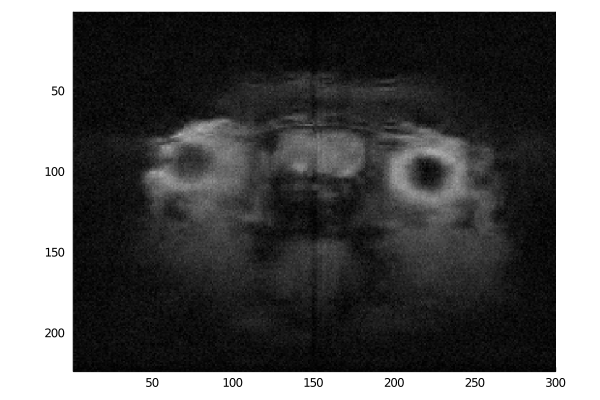

In [241]:
imshow(image2D_ncg, shift = true)

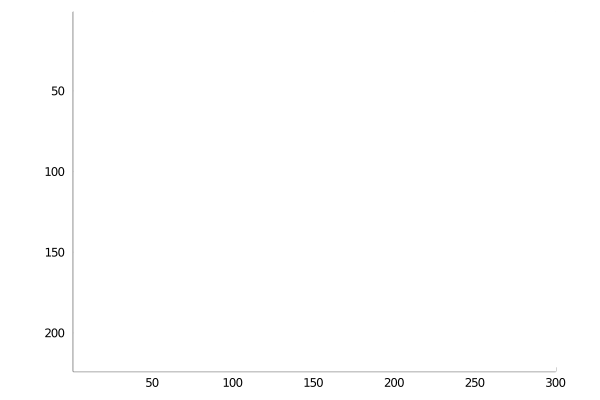

In [205]:
imshow(image2D_pogm, shift = true)

In [242]:
mse(image2D_ncg), mse(image2D_pogm)

(18.61683593333023, 1.3289006895112392e33)

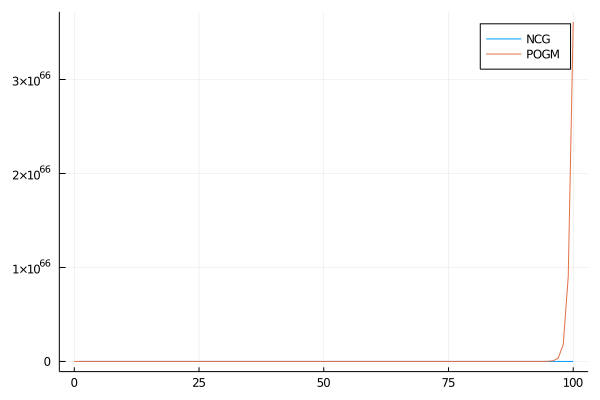

In [207]:
plot(f_vec_ncg, label="NCG")
plot!(f_vec_pogm, label="POGM")